Biostat/Biomath M257 Homework 2

subtitle: 'Due Apr 26 @ 11:59PM'

Tomoki Okuno and 805851067

System information (for reproducibility):

In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
  Threads: 2 on 4 virtual cores


Load packages:

In [2]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/07_UCLA/Class/257/02_Homework/hw2`


Status `~/Documents/07_UCLA/Class/257/02_Homework/hw2/Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [8bb1440f] DelimitedFiles v1.9.1
  [7073ff75] IJulia v1.24.2
  [86fae568] ImageView v0.12.1
  [916415d5] Images v0.26.1
  [bdcacae8] LoopVectorization v0.12.169
  [91a5bcdd] Plots v1.40.4
  [08abe8d2] PrettyTables v2.3.1
  [37e2e46d] LinearAlgebra
  [9abbd945] Profile


In [3]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random
using Plots

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

**Solution**

Most importantly, we can rewrite the objective function for efficient calculation as follows.
\begin{align*}
L(\mathbf{V}, \mathbf{W})
&= \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 \\
&= \|\mathbf{X}\|_{\text{F}}^2 -2\text{tr}(\mathbf X'\mathbf V\mathbf W) + \text{tr}(\mathbf V'\mathbf V\mathbf W\mathbf W')\\
&= \|\mathbf{X}\|_{\text{F}}^2 -2\text{dot}(\mathbf W, \mathbf V'\mathbf X) + \text{dot}(\mathbf V'\mathbf V\mathbf W, \mathbf W).
\end{align*}
There are at least three keys.

1. We should avoid calculating $\mathbf{VW}$ and $\mathbf X'\mathbf V\mathbf W$, as their sizes are large.
2. The third equation with `dot()` requires fewer matrices than the second with `tr()`.
3. We can save allocations by storing two intermediate $r$ by $r$ matrices $\mathbf V'\mathbf V$ and $\mathbf W\mathbf W'$ into a single matrix (`temp`).


I first define my own *squared* Frobenious norm (`mynorm`) and dot product (`mydot`), which are slightly faster than the original `norm()^2` and `dot()`.

In [4]:
function mynorm(A) 
    x = zero(eltype(A))
    @inbounds @simd for v in A
      @fastmath x += v * v
    end
    x # not sqrt(x) for efficiency
end

function mydot(A, B) 
    x = zero(eltype(A))
    @inbounds @simd for i in eachindex(A)
      @fastmath x += A[i] * B[i]
    end
    x
end

mydot (generic function with 1 method)

Here is a slightly slower version with the desired allocations and memory usage.

In [5]:
# function nnmf(
#     # positional arguments
#     X       :: AbstractMatrix{T}, 
#     r       :: Integer;
#     # kw arguments
#     maxiter :: Integer = 1000, 
#     tolfun  :: Number = 1e-4,
#     V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
#     W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
#     ) where T <: AbstractFloat

#     # preallocate necessary matrices
#     # WWt    = similar(X, r, r)
#     # VtV    = similar(X, r, r)
#     # VtVWWt = similar(X, r, r)
#     temp   = similar(X, r, r) # WWt or VtV
#     XWt    = similar(X, size(X, 1), r) # for update V and obj
#     VWWt   = similar(X, size(X, 1), r) # for update V and obj
#     VtX    = similar(X, r, size(X, 2)) # for update W 
#     VtVW   = similar(X, r, size(X, 2)) # for update W
#     # WtVtX  = similar(X, size(X, 2), size(X, 2)) # unnecessary with dot() instead of tr()
    
#     # obj at start point
#     normXsq = mynorm(X) # squared internaly in my own function
#     mul!(XWt, X, W')
#     mul!(temp, W, W') # WWt
#     mul!(VWWt, V, temp)
#     # obj = norm(X - VW)^2 # very memory intensive
#     # obj = normXsq - 2tr(WtVtX) + tr(VtVWWt)
#     obj = normXsq - 2mydot(XWt, V) + mydot(V, VWWt)
#     niter = 0
    
#     for iter in 1:maxiter
        
#         # mul!(XWt, X, W') # XWt from the previous iteration
#         # mul!(temp, W, W') # WWt from the previous iteration
#         # mul!(VWWt, V, temp) # VWWt from the previous iteration 
        
#         # update V
#         @. V *= XWt / VWWt
        
#         # update matrices with V for W
#         mul!(VtX, V', X)
#         mul!(temp, V', V)   
#         mul!(VtVW, temp, W) 

#         # update W
#         @. W *= VtX / VtVW

#         # update matrices with W for obj and V (next iteration)
#         mul!(XWt, X, W') 
#         mul!(temp, W, W')   
#         mul!(VWWt, V, temp)

#         # update obj
#         obj_old = obj    
#         obj = normXsq - 2mydot(XWt, V) + mydot(V, VWWt)

#         # convergence check
#         if abs(obj - obj_old) < tolfun * (abs(obj_old) + 1)
#             niter = iter
#             break
#         end
#     end
#     # Output
#     V, W, obj, niter
# end

The final version is as follows.

In [6]:
function nnmf(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    ) where T <: AbstractFloat
    
    # preallocate necessary matrices
    temp   = similar(X, r, r) # WWt or VtV
    XWt    = similar(X, size(X, 1), r) # for update V 
    VWWt   = similar(X, size(X, 1), r) # for update V
    VtX    = similar(X, r, size(X, 2)) # for update W and obj
    VtVW   = similar(X, r, size(X, 2)) # for update W and obj
    
    # obj at start point
    normXsq = mynorm(X) # squared internaly in my own function
    mul!(temp, V', V) # VtV here
    mul!(VtVW, temp, W) 
    mul!(VtX, V', X)
    obj = normXsq - 2mydot(W, VtX) + mydot(VtVW, W)
    # obj = norm(X - VW)^2 # very memory intensive
    # obj = normXsq - 2tr(WtVtX) + tr(VtVWWt)
    niter = 0
    
    for iter in 1:maxiter

        mul!(XWt, X, W')
        mul!(temp, W, W') # WWt here
        mul!(VWWt, V, temp)
        
        # update V
        @. V *= XWt / VWWt

        mul!(VtX, V', X)
        mul!(temp, V', V) # VtV here
        mul!(VtVW, temp, W) 

        # update W
        @. W *= VtX / VtVW

        mul!(VtVW, temp, W)

        # update obj
        obj_old = obj
        obj = normXsq - 2mydot(W, VtX) + mydot(VtVW, W)

        # convergence check
        if abs(obj - obj_old) < tolfun * (abs(obj_old) + 1)
            niter = iter
            break
        end
    end
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

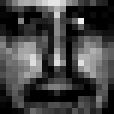

In [7]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

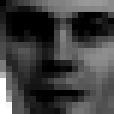

In [8]:
colorview(Gray, reshape(X[10, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

**Solution**

In [17]:
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]),
        copyto!(W0, W0full[1:r, :])
        )
    println("obj = $obj, niter = $niter")
end

r=10
  329.183 ms (9 allocations: 437.19 KiB)
obj = 11730.388009855407, niter = 239
r=20
  406.849 ms (9 allocations: 875.44 KiB)
obj = 8497.222317850872, niter = 394
r=30
  524.614 ms (9 allocations: 1.28 MiB)
obj = 6621.627345486937, niter = 482
r=40
  497.877 ms (9 allocations: 1.72 MiB)
obj = 5256.663870564022, niter = 581
r=50
  666.540 ms (10 allocations: 2.15 MiB)
obj = 4430.201581697547, niter = 698


The objective values were comparable to, and slightly better than, his results with the same number of iterations. Additionally, my memory allocation and usage matched his.

### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

Choose $r = 50$ for Q1.6. First, we start with the original $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$ to obtain the objective value and $(\mathbf{V}, \mathbf{W})$.

In [18]:
r = 50 # [10, 20, 30, 40, 50]
println("r=$r")
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
V1, W1, obj, niter = nnmf(X, r, V = V0, W = W0)
# @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
#     copyto!(V0, V0full[:, 1:r]), 
#     copyto!(W0, W0full[1:r, :])
#     )
println("obj = $obj, niter = $niter")
# display(V1)
# display(W1)

r=50
obj = 4430.201581697547, niter = 698


Next, I create different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$ whose elements are $\text{U}(0, 1)$ and then run algorithm with $r = 50$.

In [19]:
r = 50 # [10, 20, 30, 40, 50]
println("r=$r")
Random.seed!(257)
V0 = Random.rand!(similar(X, size(X, 1), r))
W0 = Random.rand!(similar(X, r, size(X, 2)))
V2, W2, obj, niter = nnmf(X, r, V = V0, W = W0)
# @btime nnmf($X, $r, V = $V0, W = $W0)
println("obj = $obj, niter = $niter")
# display(V2)
# display(W2)

r=50
obj = 4446.331825886533, niter = 691


We obtained a slightly larger objective value and a different iteration number. As expected from the difference in `obj`, the two sets of $(\mathbf{V}, \mathbf{W})$ were also different as follows.

In [20]:
# check the difference at different levels of tolerance
isapprox(V1, V2, atol = 1e-2) && isapprox(W1, W2, atol = 1e-2),
isapprox(V1, V2, atol = 1e-1) && isapprox(W1, W2, atol = 1e-1)

(false, false)

Obtaining a larger objective value indicates that these starting points led to a local minimum.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

In [21]:
r = 50 # [10, 20, 30, 40, 50]
println("r=$r")
V0 = ones(size(X, 1), r)
W0 = ones(r, size(X, 2))
V3, W3, obj, niter = nnmf(X, r, V = V0, W = W0)
println("obj = $obj, niter = $niter")
# display(V3)
# display(W3)

r=50
obj = 25297.016511082737, niter = 3


In [22]:
isapprox(V1, V3, atol = 1e-0) && isapprox(W1, W3, atol = 1e-0)

false

The objective value and $(\mathbf{V}, \mathbf{W})$ were completely different.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

**Solution**

Recall that I stored the original $\mathbf{W}$ for $r = 50$ as `W1`.

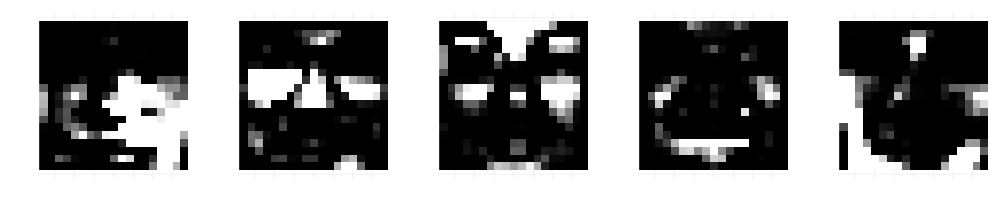

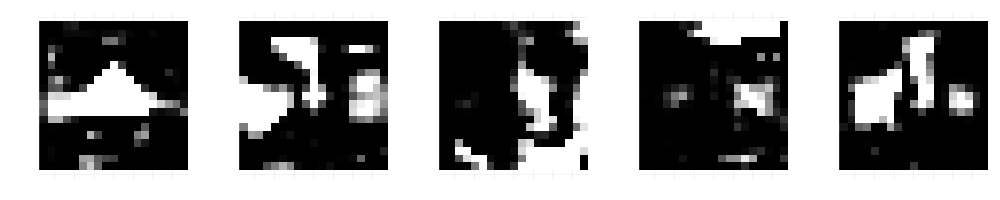

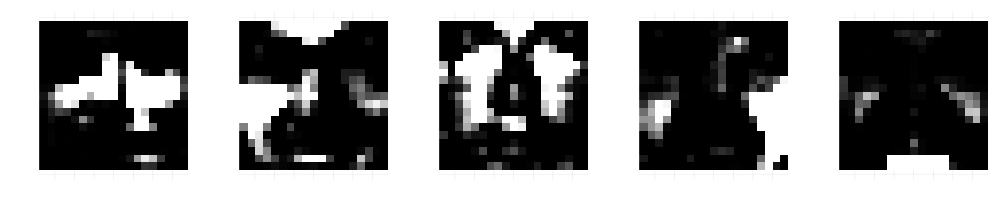

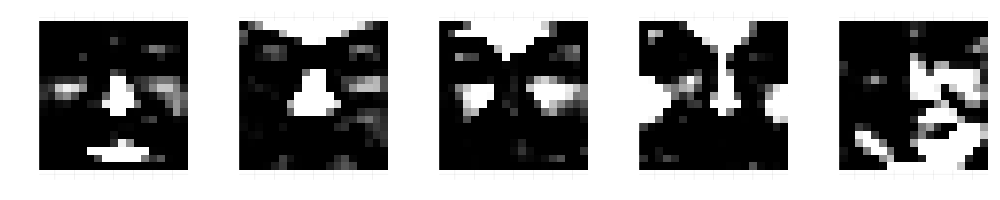

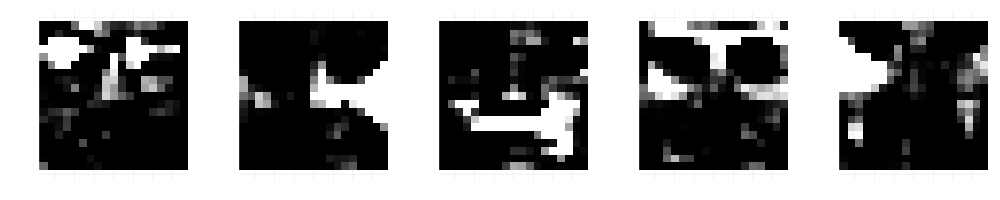

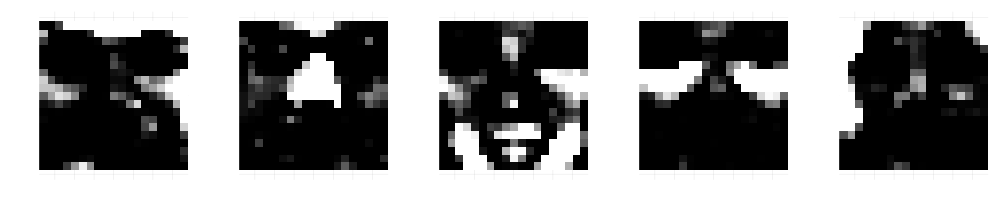

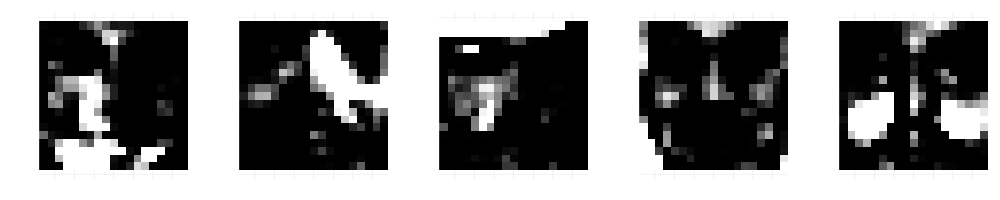

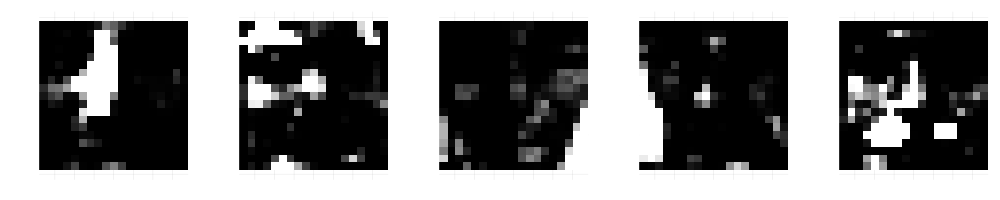

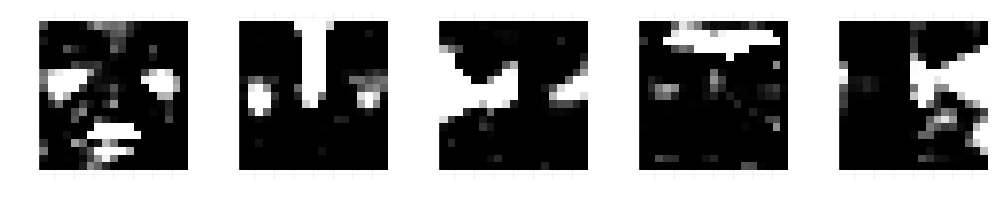

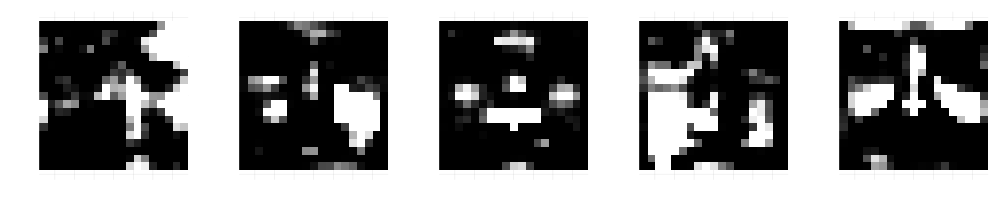

In [23]:
# put rows of W at rank r = 50 (obtained before)
images = [colorview(Gray, reshape(W1[i, :], 19, 19)) for i in 1:50]

for i in 1:5:46
    p = plot(layout = (1, 5), size = (1000, 200)) 
    for j in i:(i + 4)
        heatmap!(p, images[j], c = :grays, axis = false, subplot = (j - i + 1))  
    end
    display(p)
end 

Each row in $\mathbf W$ seems to represent a part of the original face.

### Q1.7 GPU (optional)

Investigate the GPU capabilities of your computer. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

**Solution**